# Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)

## 1.0 Initialisation

### 1.1 Importing the Libraries
Necessary libraries for dataframes, data manipulation, visualisation & machine learning algorithms

In [9]:
# PROBLEM AREA : pandas support the current version of NumPy, had to downgrade to 1.26.4
# Uninstall the current version of NumPy
#!pip uninstall -y numpy

# Install downgraded version of NumPy
#!pip install numpy==1.26.4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import HDBSCAN
from sklearn.metrics import calinski_harabasz_score
from mpl_toolkits.mplot3d import Axes3D

### 1.2 Loading Datasets

In [3]:
df_scaled = pd.read_csv('../raw_data/customer_standard_scaled.csv', index_col='CUST_ID')
df_pca = pd.read_csv('../raw_data/customer_pca_5.csv', index_col='CUST_ID')
df_tsne = pd.read_csv('../raw_data/customer_tsne_3.csv', index_col='CUST_ID')
df_umap = pd.read_csv('../raw_data/customer_umap_3.csv', index_col='CUST_ID')

## 2.0 Model Building
#### 2.1 Functions for Visualisation & Evaluation
Helper functions to be used in the model building process

In [4]:
def evaluate_clustering(df, labels):
    valid_labels = labels[labels != -1]  # Exclude noise points
    valid_data = df[labels != -1]
    if len(set(valid_labels)) > 1:
        ch_score = calinski_harabasz_score(valid_data, valid_labels)
    else:
        ch_score = 0  # or np.nan
    return ch_score

def visualize_clusters(df, labels, axes, s=10):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2],
                         c=labels, cmap='viridis', s=s)
    plt.colorbar(scatter).set_label('Cluster')
    ax.set_title('3D Scatter Plot of Clusters')
    ax.set_xlabel(f'{axes} 1')
    ax.set_ylabel(f'{axes} 2')
    ax.set_zlabel(f'{axes} 3')
    plt.show()

#### 2.2 Perform Clustering on different Preprocessed Datasets
To determine the best dataset for clustering <br><br>
Conclusion : \



Clustering on Scaled dataset:
Initial Calinski-Harabasz Score: 255.39307607905943


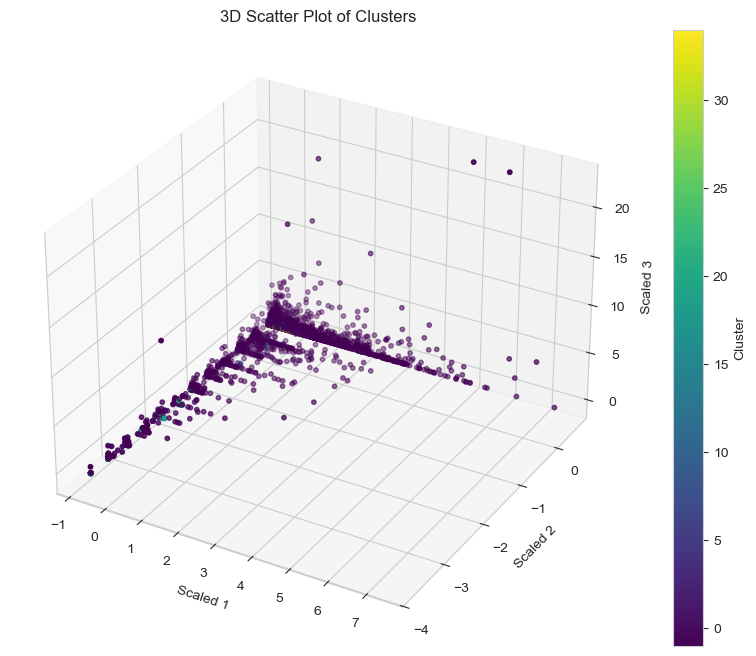

Number of clusters: 35
Number of noise points: 2929

Clustering on PCA dataset:
Initial Calinski-Harabasz Score: 17.936222261060003


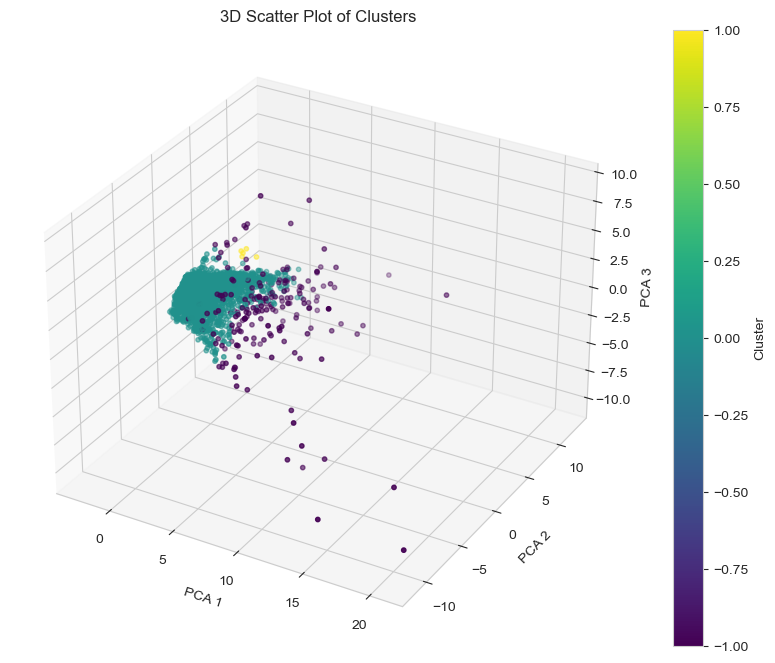

Number of clusters: 2
Number of noise points: 200

Clustering on t-SNE dataset:
Initial Calinski-Harabasz Score: 1036.274786862754


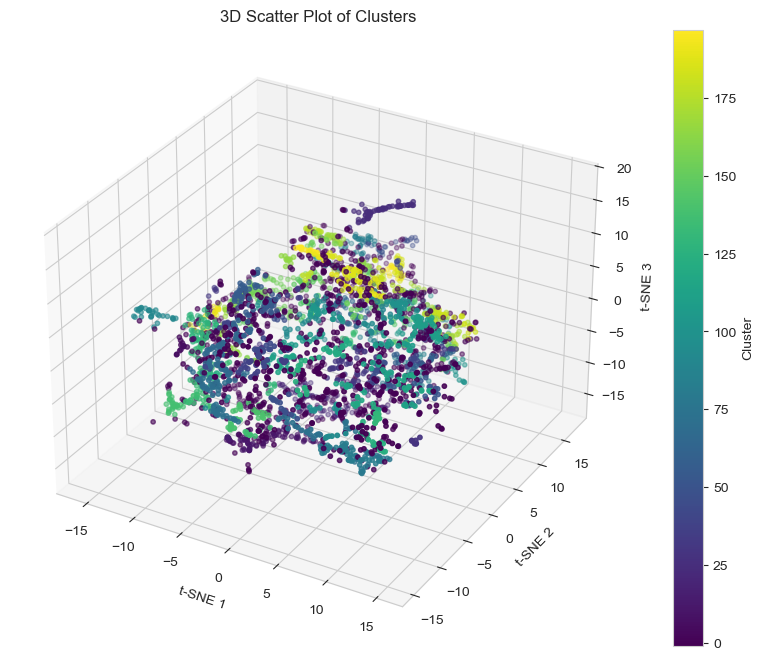

Number of clusters: 198
Number of noise points: 1049

Clustering on UMAP dataset:
Initial Calinski-Harabasz Score: 4237.591508738261


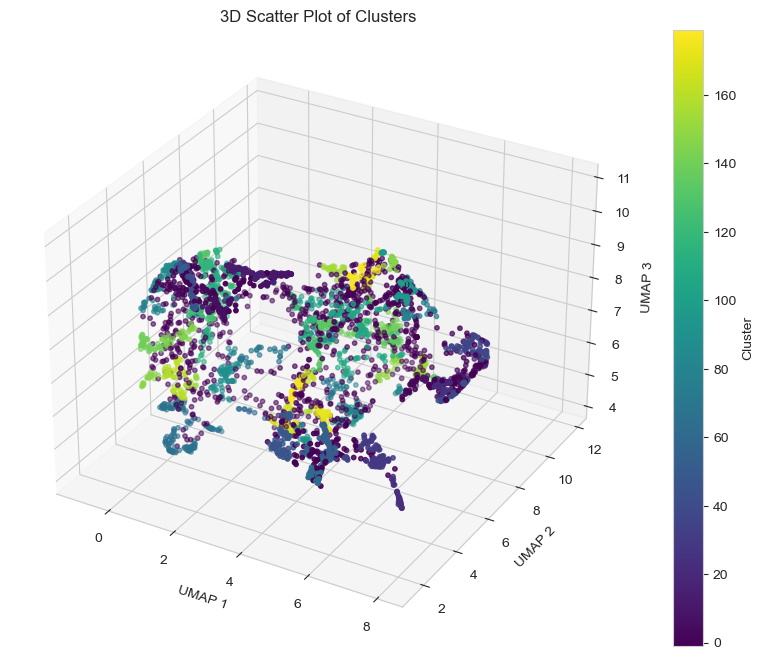

Number of clusters: 180
Number of noise points: 1104


In [5]:
datasets = [
    (df_scaled, "Scaled"),
    (df_pca, "PCA"),
    (df_tsne, "t-SNE"),
    (df_umap, "UMAP")
]

for df, name in datasets:
    print(f"\nClustering on {name} dataset:")

    # Initial clustering
    hdbscan_clustering = HDBSCAN(min_cluster_size=5, min_samples=5)
    labels = hdbscan_clustering.fit_predict(df)

    # Evaluate initial clustering
    initial_ch_score = evaluate_clustering(df, labels)
    print(f"Initial Calinski-Harabasz Score: {initial_ch_score}")

    # Visualize initial clustering
    visualize_clusters(df, labels, name)

    # Print number of clusters and noise points
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")

#### 2.3 Fine-tuning the Model
To determine the best parameters for the model

In [6]:
best_df = df_umap # since umap performs best

# Fine-tune min_cluster_size and min_samples
min_cluster_sizes = range(5, 51, 5)
min_samples_range = range(1, 11)
ch_scores = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_range:
        hdbscan_clustering = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = hdbscan_clustering.fit_predict(best_df)
        ch_scores.append((min_cluster_size, min_samples, evaluate_clustering(best_df, labels)))

# Find the best parameters
best_params = max(ch_scores, key=lambda x: x[2])
print(f"Best parameters: min_cluster_size={best_params[0]}, min_samples={best_params[1]}")
print(f"Best Calinski-Harabasz Score: {best_params[2]}")

Best parameters: min_cluster_size=5, min_samples=1
Best Calinski-Harabasz Score: 4360.5027500592905


## 3.0 Final Model & Evaluation
#### 3.1 HDBSCAN Model with Best Parameters

In [7]:
final_model = HDBSCAN(min_cluster_size=best_params[0], min_samples=best_params[1])
final_labels = final_model.fit_predict(best_df)

print("\nFinal model evaluation:")
print(f"Calinski-Harabasz Score: {evaluate_clustering(best_df, final_labels)}")


Final model evaluation:
Calinski-Harabasz Score: 4360.5027500592905


#### 3.2 Visualising the Final Clusters

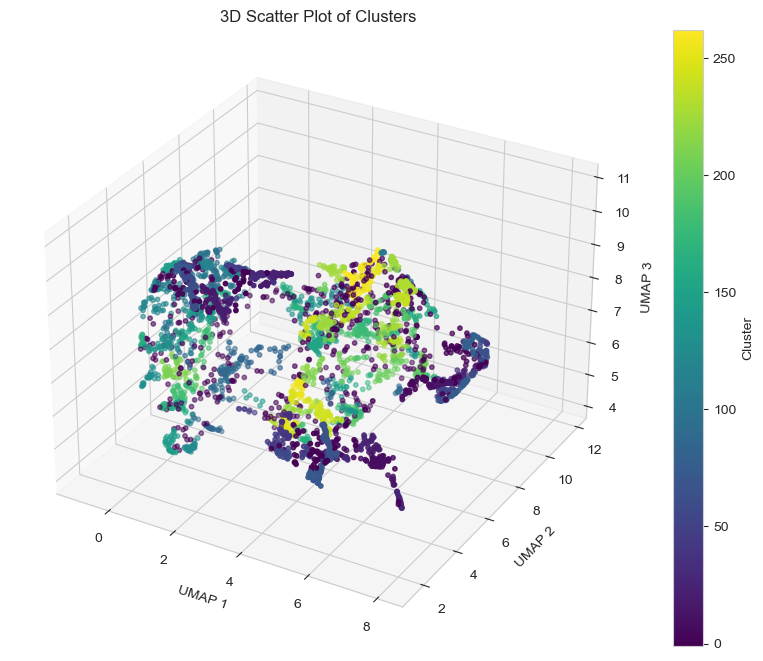


Cluster Means:
            UMAP1      UMAP2     UMAP3
Cluster                               
0        3.917026  11.577372  5.239410
1        3.900441  11.636001  5.204913
2        3.836248  11.768289  5.126111
3        3.817038  11.818346  5.091744
4        7.401790   4.708886  8.033895
...           ...        ...       ...
258      4.217396   7.723548  8.654548
259      4.115947   7.176926  8.933799
260      4.004474   7.107878  9.068975
261      4.225520   8.171920  9.166364
262      4.282310   8.306696  9.328325

[263 rows x 3 columns]

Number of clusters: 263
Number of noise points: 687


In [8]:
visualize_clusters(best_df, final_labels, "UMAP")

# Calculate and display cluster means (excluding noise points)
best_df['Cluster'] = final_labels
cluster_means = best_df[best_df['Cluster'] != -1].groupby('Cluster').mean()
print("\nCluster Means:")
print(cluster_means)

# Print number of clusters and noise points
n_clusters = len(set(final_labels)) - (1 if -1 in final_labels else 0)
n_noise = list(final_labels).count(-1)
print(f"\nNumber of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")